In [1]:
%load_ext autoreload
# to make modification in .py file type %autoreload

%load_ext line_profiler
#for finding out how long code takes to run
#an example of how to get diagnostics on functions
#%lprun -f ff.generate_map_full ff.generate_map_full(384, A_BB, alpha_BB, beta_sigma, freqs, nu0)

In [2]:
#trying to consolidate the work so far into a cohesive document and notation. Pushing definitions into 
#separate .py file

#------packages-------------------
%pylab inline
import time
import healpy as hp
import matplotlib.pyplot as plt
import foreground_functions as ff
from scipy.optimize import curve_fit, minimize

Populating the interactive namespace from numpy and matplotlib


# parameters for generating map

In [3]:
nside = 128
A = 1.7e3
alpha = -3.0
beta = -3.2
gamma = -2.5
ells = np.arange(3*nside)
freqs = np.linspace(30, 300, 5)*1.e9

# define the model with these parameters (for comparison)

In [4]:
input_model = ff.model(freqs, A, alpha, beta, gamma)
input_model.shape

(5, 384)

# define 2d and 1d data

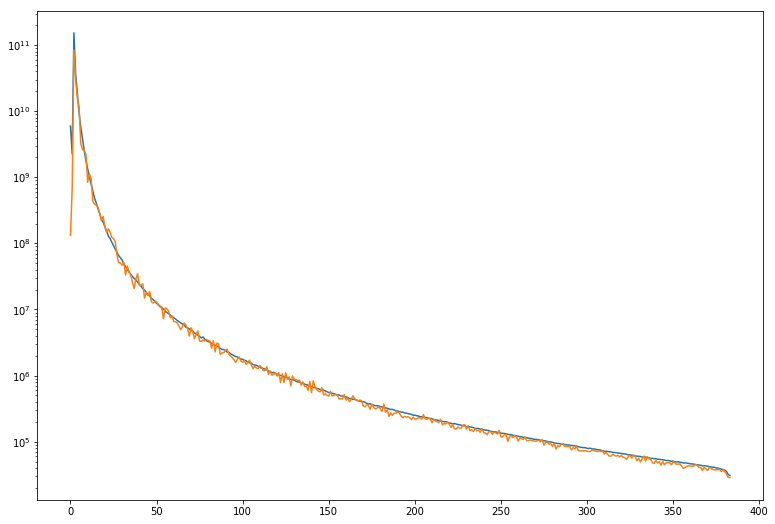

In [5]:
#averaged 100 PS
mean_PS_data = np.load('reference_mean_PS.npy').T
#reference single PS we're trying to fit
PS_data = np.load('reference_PS.npy')
figure(figsize(13,9))
semilogy(mean_PS_data[0])
semilogy(PS_data[0])

In [6]:
%autoreload

In [7]:
%lprun -f ff.full_model ff.full_model(ells, freqs, A, alpha, beta, gamma)

In [8]:
%lprun -f ff.get_wigner_sum ff.get_wigner_sum()

In [9]:
#try residual stuff with this new 'full_model' function
def residuals(params, ells, freqs, data):
    chi2 = 0
    amp, alpha, beta, gamma = params
    model = ff.full_model(ells, freqs, amp, alpha, beta, gamma)

    #set up array of 2/(2*ell+1) then multiply by C_ell^2
    var = np.zeros((len(freqs),len(ells)))
    for ell in range(len(ells)):
        var[:,ell] = 2/(2*ell+1)
    cosmic_var = var * model**2
    chi2 = (data[2:] - model[2:])**2 / cosmic_var[2:]
#     print(chi2)
    return np.sum(chi2)

In [10]:
default_params = [A, alpha, beta, gamma]

In [11]:
%lprun -f residuals residuals(default_params, ells, freqs, PS_data)

# Fit 0: test if minimize is moving

In [12]:
start=time.time()
result = minimize(residuals, [1e3, -1, -1, -3], args=(ells, freqs, PS_data), 
                  bounds=((None, None), (None, None), (None, None), (None, -2.01)))
print(time.time()-start)

19.316211938858032


In [13]:
result

      fun: 1433.8846245108934
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.27373675e-05,  5.29780664e-03,  1.27101885e-02,  9.09494702e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 490
      nit: 59
   status: 0
  success: True
        x: array([1284.73745634,   -2.95617139,   -2.88174321,   -4.40224655])

In [32]:
result

      fun: 2811.7576517924444
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.04347385,  0.00645741, -0.00159162,  0.00463842])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 150
      nit: 15
   status: 0
  success: True
        x: array([999.9979063 ,  -4.24334977,  -3.85019602,  -2.76123515])

In [14]:
x = result.x

In [15]:
fitted_model = ff.model(freqs, x[0], x[1], x[2], x[3])
fitted_model.shape

(5, 384)

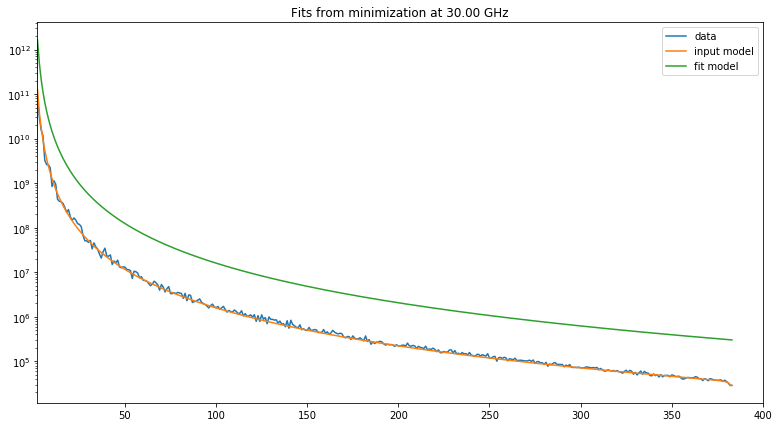

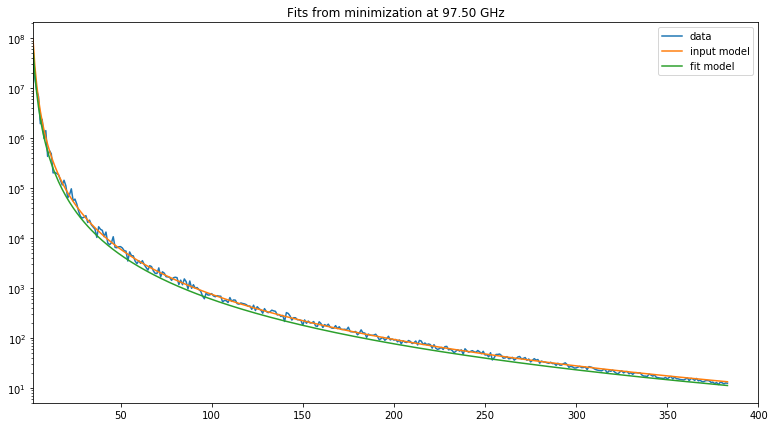

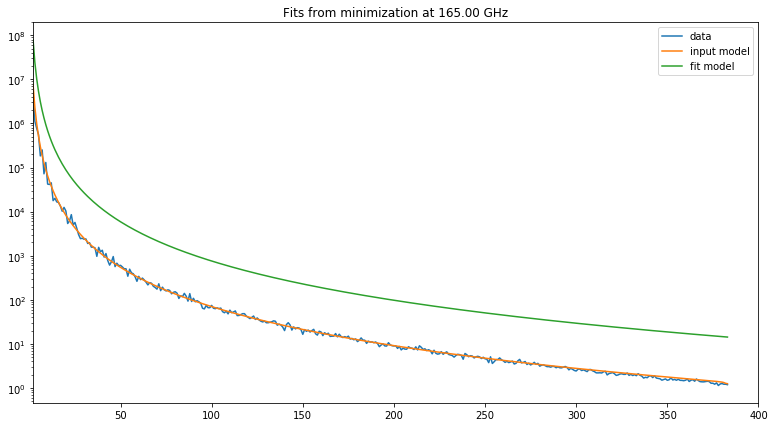

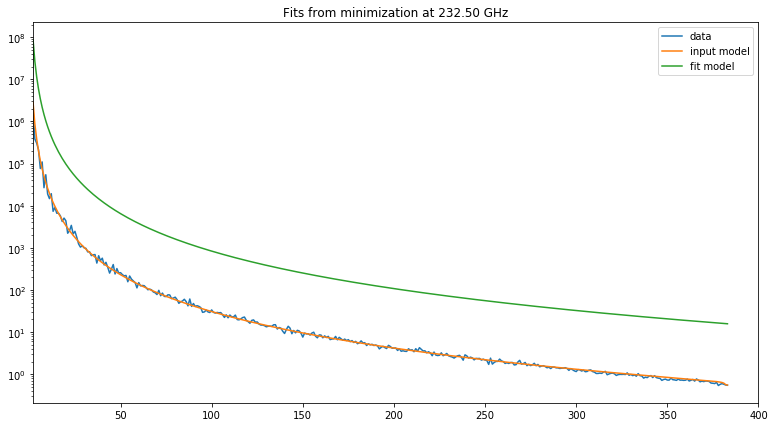

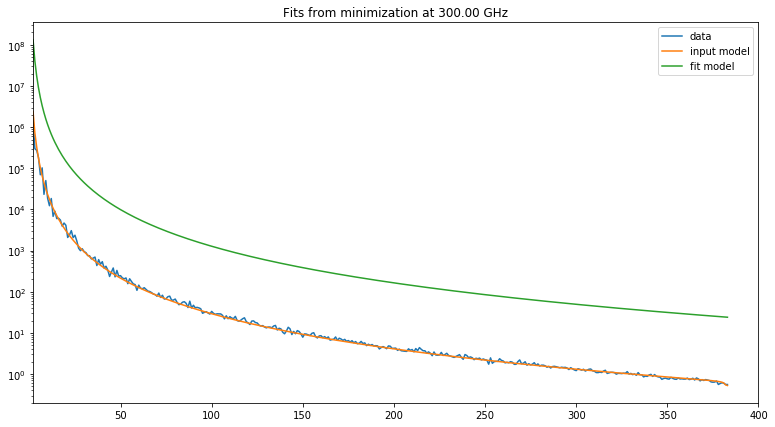

In [16]:
for i in range(len(freqs)):
    figure(figsize=(13,7))
    semilogy(PS_data[i], label='data')
    semilogy(input_model[i], label='input model')
    semilogy(fitted_model[i], label='fit model')
    title('Fits from minimization at {:.2f} GHz'.format(freqs[i]/1e9))
    legend()
    xlim(2,400)

In [69]:
#okay, so it's kind of worked, though not super well. But it's running and moving.
#Test if the system is consistent now, with same input vector should get same output

# Fit 1: see if system is deterministic

In [69]:
start=time.time()
result_1 = minimize(residuals, [1e3, -1, -1, -3], args=(ells, freqs, PS_data),
                    bounds=((None, None), (None, None), (None, None), (None, -2.01)))
print(time.time()-start)

437.2117500305176


In [70]:
result_1

      fun: 2184.1894873243464
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([   -5.0674771 ,  2046.77053262,  -821.01719272, -4946.65114275])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 435
      nit: 43
   status: 0
  success: True
        x: array([1000.00442155,   -2.68835596,   -3.50661081,   -2.03650309])

In [71]:
x1 = result_1.x

In [72]:
x-x1

array([0., 0., 0., 0.])

In [74]:
#good, so model is deterministic as it should be now. Now can test different initial points and/or constraints/methods

# Fit 3: start at correct amplitude and see what others are found as

In [73]:
start=time.time()
result3 = minimize(residuals, [A, -1, -1, -3], args=(ells, freqs, PS_data),
                   bounds=((None, None), (None, None), (None, None), (None, -2.01)))
print(time.time()-start)

511.7546238899231


In [74]:
x3 = result3.x
print(x3)

[1175.34527458   -2.95739727   -2.75765492  -15.10557388]


In [ ]:
#what? It moved away from the correct value of A but found a very wrong value of gamma...

In [75]:
fit3= ff.model(freqs, x3[0], x3[1], x3[2], x3[3])

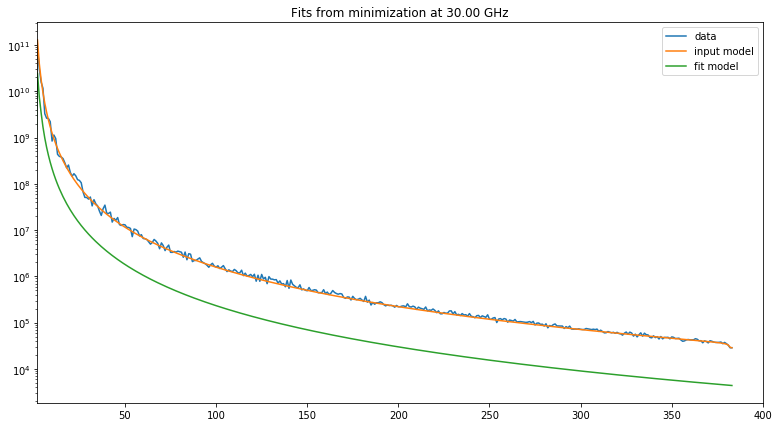

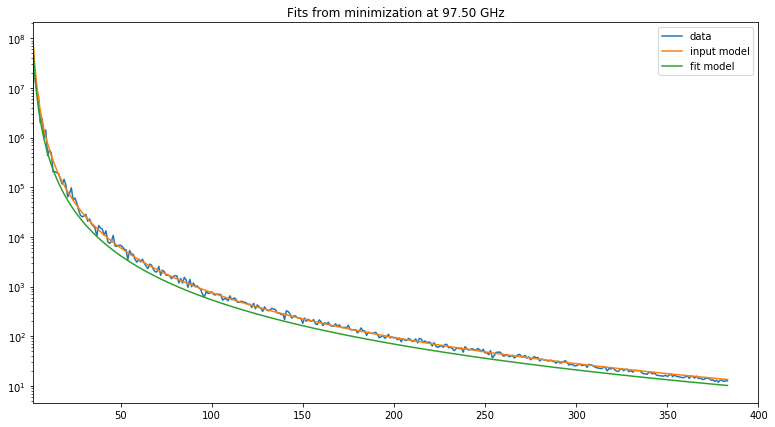

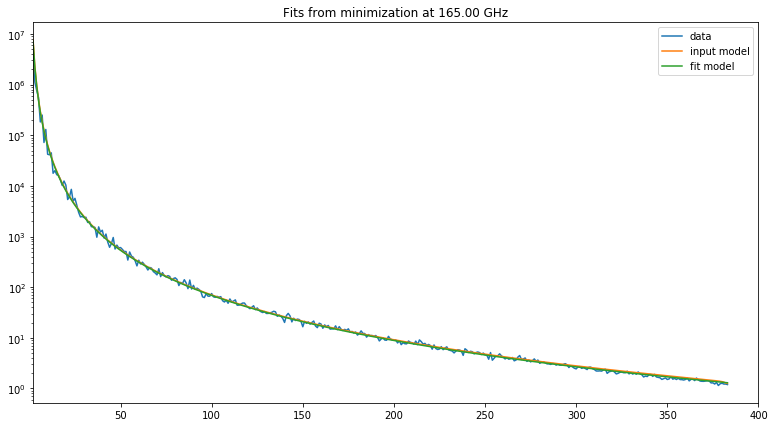

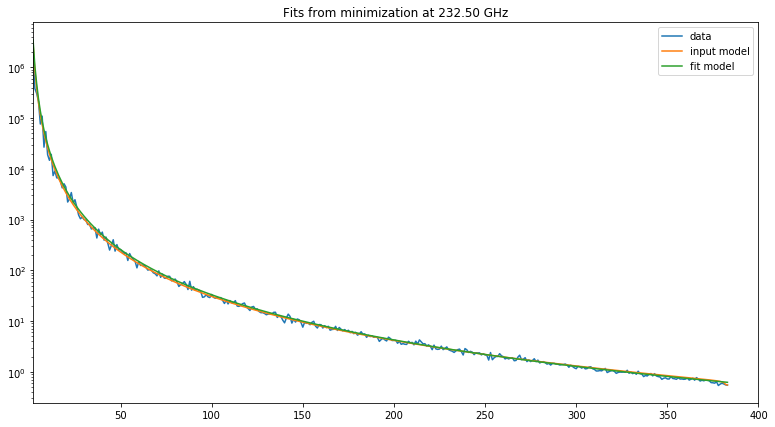

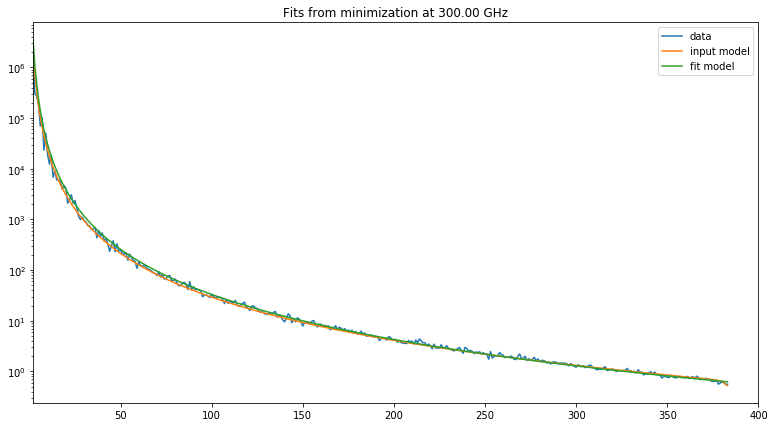

In [76]:
for i in range(len(freqs)):
    figure(figsize=(13,7))
    semilogy(PS_data[i], label='data')
    semilogy(input_model[i], label='input model')
    semilogy(fit3[i], label='fit model')
    title('Fits from minimization at {:.2f} GHz'.format(freqs[i]/1e9))
    legend()
    xlim(2,400)

In [ ]:
#let's plot the residuals for both the input model and the extracted model in this case.

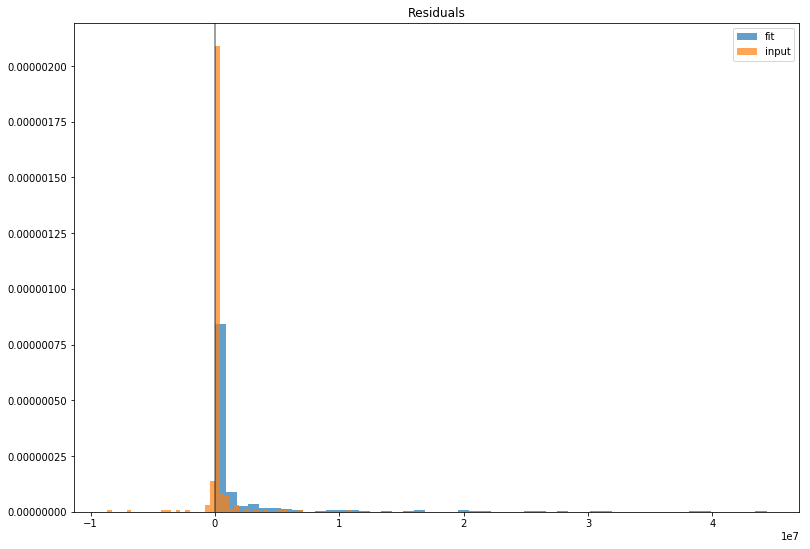

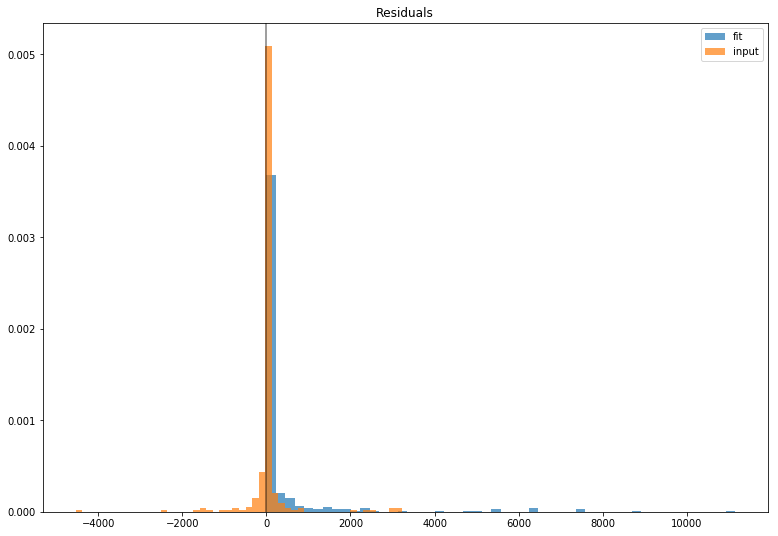

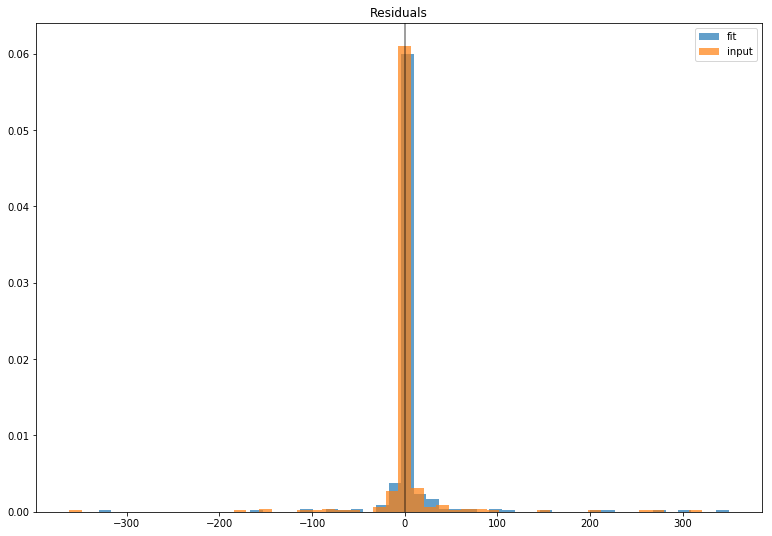

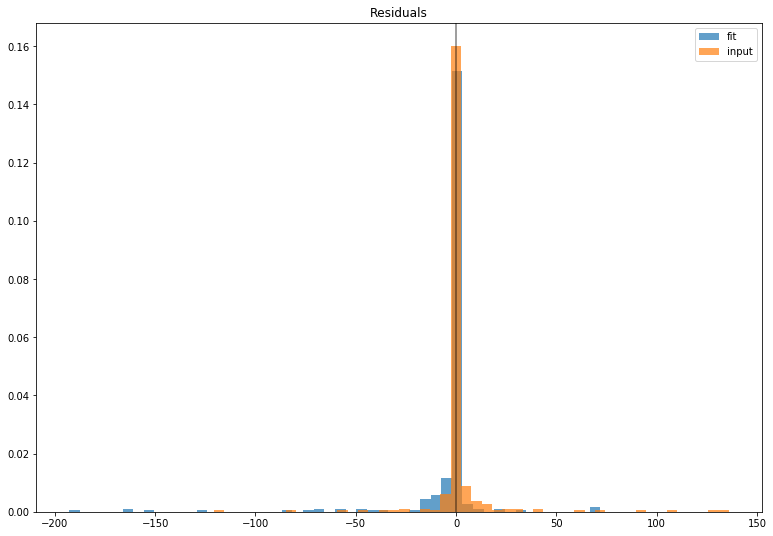

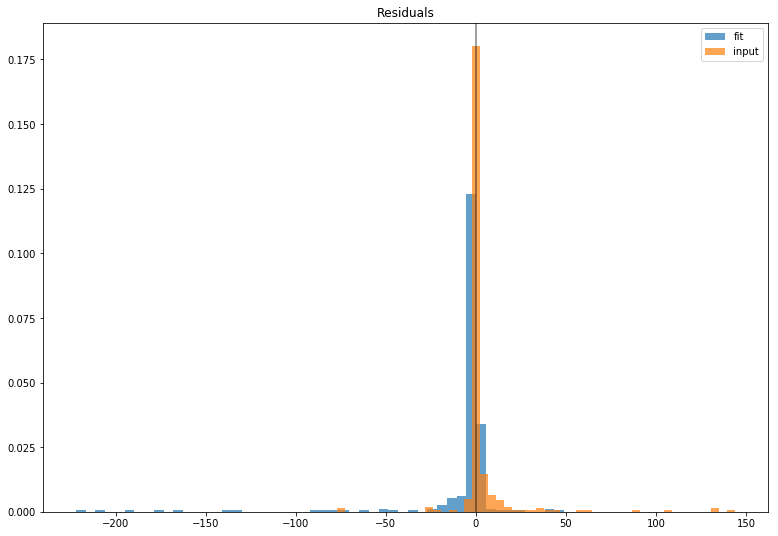

In [93]:
for i in range(len(freqs)):
    figure()
    axvline(x=0, color='k', alpha=0.5)
    hist(PS_data[i][30:]-fit3[i][30:], density=True, bins=50, alpha=0.7, label='fit')
    hist(PS_data[i][30:]-input_model[i][30:], density=True, bins=50, alpha=0.7, label='input')
    title('Residuals')
    legend()


# Okay, so several problems, apparently the minimizer will move from initializing amplitude, however, it did so here and settled on a terrible value of $A$ and $\gamma$ ($\gamma=-15$!)
Try again but this time bounding stronger on gamma

In [94]:
start=time.time()
result4 = minimize(residuals, [1e3, -1, -1, -3], args=(ells, freqs, PS_data),
                   method='L-BFGS-B', bounds=((None, None), (None, None), (None, None), (None, -2.01)))
print(time.time()-start)

422.6356658935547


In [95]:
result4

      fun: 2184.1894873243464
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([   -5.0674771 ,  2046.77053262,  -821.01719272, -4946.65114275])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 435
      nit: 43
   status: 0
  success: True
        x: array([1000.00442155,   -2.68835596,   -3.50661081,   -2.03650309])

In [96]:
#okay, so L-BFGS-B also doesn't move from the starting position given here

In [97]:
start=time.time()
result5 = minimize(residuals, [A, -1, -1, -3], args=(ells, freqs, PS_data),
                   method='L-BFGS-B', bounds=((None, None), (None, None), (None, None), (None, -2.01)))
print(time.time()-start)

542.5621719360352


In [98]:
result5

      fun: 1464.782057370558
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.27373675e-05, -2.44654075e-02, -3.61524144e-02,  9.09494702e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 520
      nit: 78
   status: 0
  success: True
        x: array([1175.34527458,   -2.95739727,   -2.75765492,  -15.10557388])

In [99]:
result5.x - result3.x

array([0., 0., 0., 0.])

In [100]:
#okay, so L-BFGS-B is doing the same thing as the default method at least...

In [102]:
#what about tighter bounding? (on gamma)

In [103]:
start=time.time()
result6 = minimize(residuals, [1e3, -1, -1, -3], args=(ells, freqs, PS_data),
                   method='L-BFGS-B', bounds=((None, None), (None, None), (None, None), (-4, -2.01)))
print(time.time()-start)

455.2660732269287


In [105]:
print(result6)
x6 = result6.x

      fun: 1941.623161293513
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.17303137, -0.01159606,  0.00391083,  0.03929017])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 445
      nit: 46
   status: 0
  success: True
        x: array([1000.00133073,   -2.78544822,   -3.70983086,   -2.01020386])


In [106]:
fit6 = ff.model(freqs, x6[0], x6[1], x6[2], x6[3])

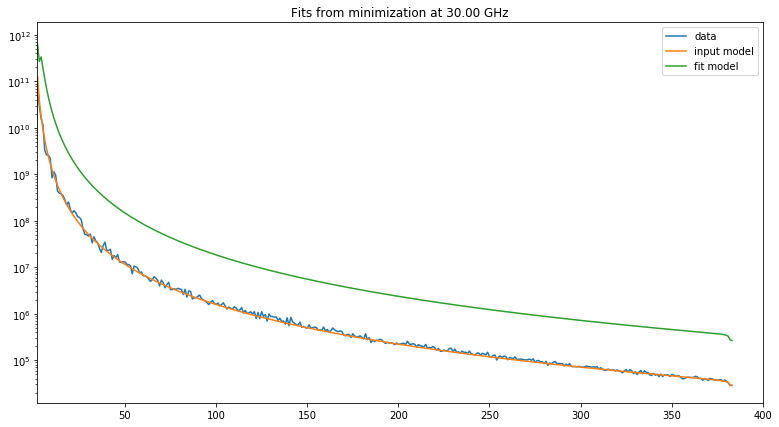

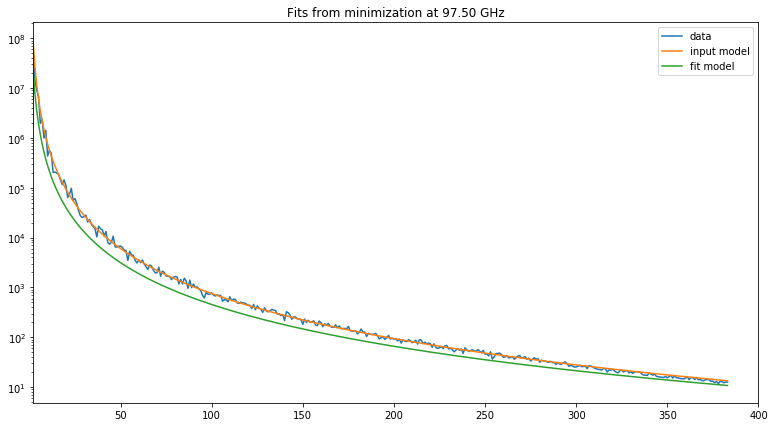

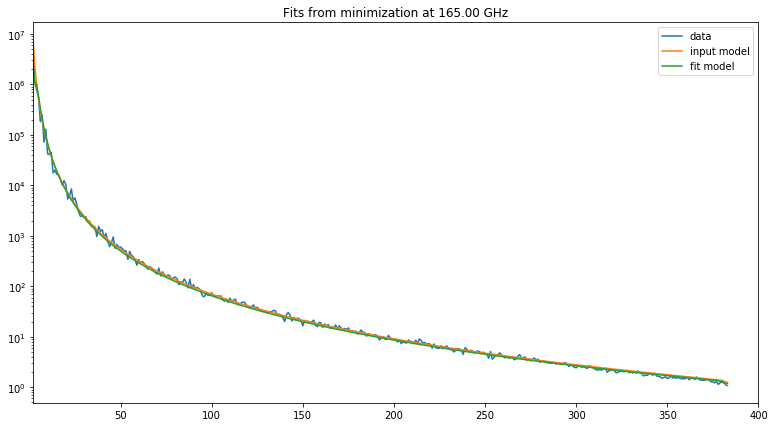

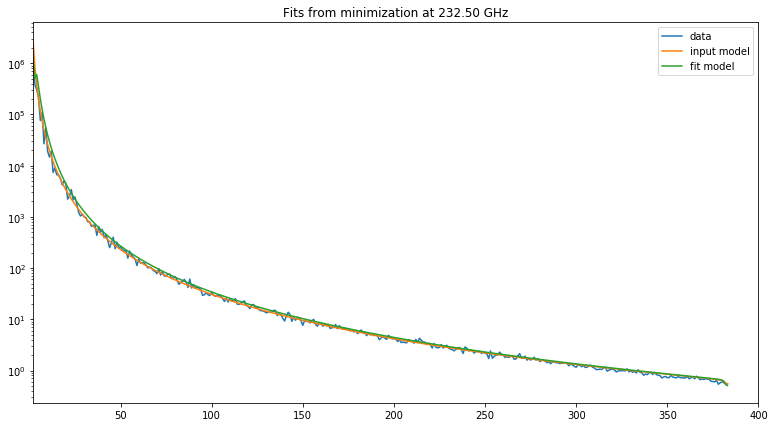

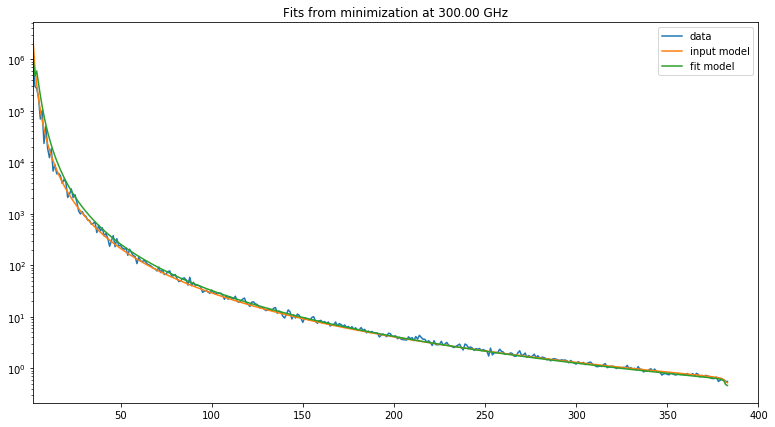

In [107]:
for i in range(len(freqs)):
    figure(figsize=(13,7))
    semilogy(PS_data[i], label='data')
    semilogy(input_model[i], label='input model')
    semilogy(fit6[i], label='fit model')
    title('Fits from minimization at {:.2f} GHz'.format(freqs[i]/1e9))
    legend()
    xlim(2,400)

In [108]:
#try a different starting position for amplitude to see if it moves?

In [109]:
start=time.time()
result7 = minimize(residuals, [1.3e3, -1, -1, -3], args=(ells, freqs, PS_data),
                   method='L-BFGS-B', bounds=((None, None), (None, None), (None, None), (None, -2.01)))
print(time.time()-start)

596.9793248176575


In [114]:
print(result7)
x7 = result7.x

      fun: 1939.1901515091076
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.72848411e-04,  3.14275894e-01, -4.92491381e-01, -3.44739419e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 580
      nit: 78
   status: 0
  success: True
        x: array([1026.21162697,   -2.7693349 ,   -3.69018028,   -2.01296521])


In [117]:
#okay, so it can move from starting position but it doesn't do very well with that.

In [115]:
fit7 = ff.model(freqs, x7[0], x7[1], x7[2], x7[3])

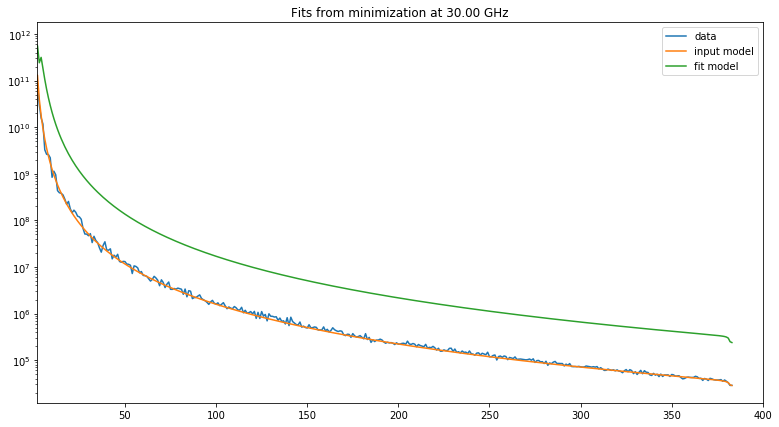

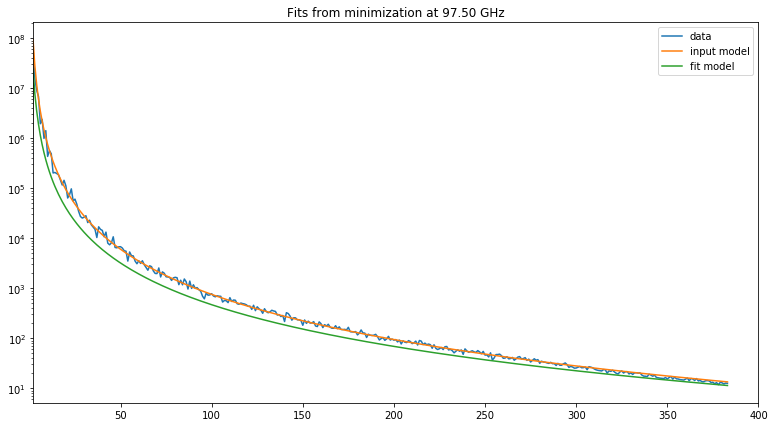

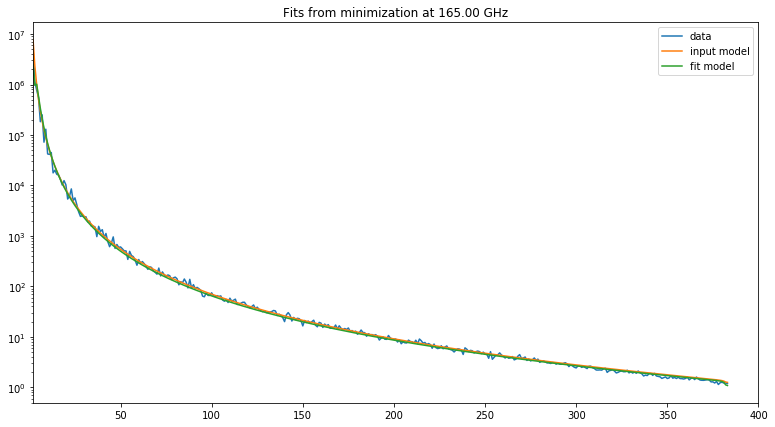

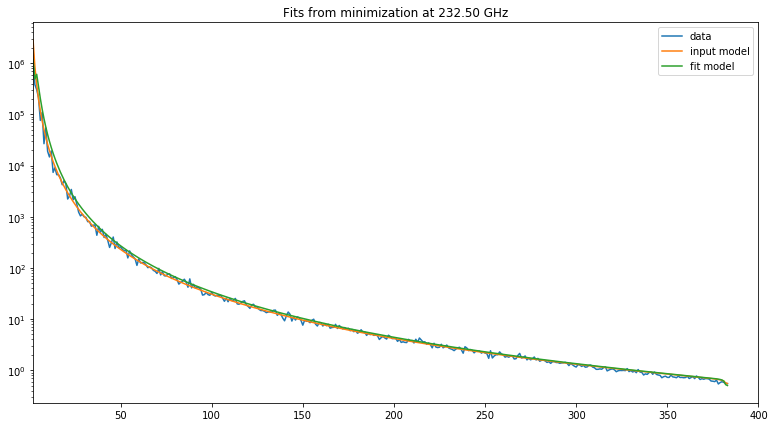

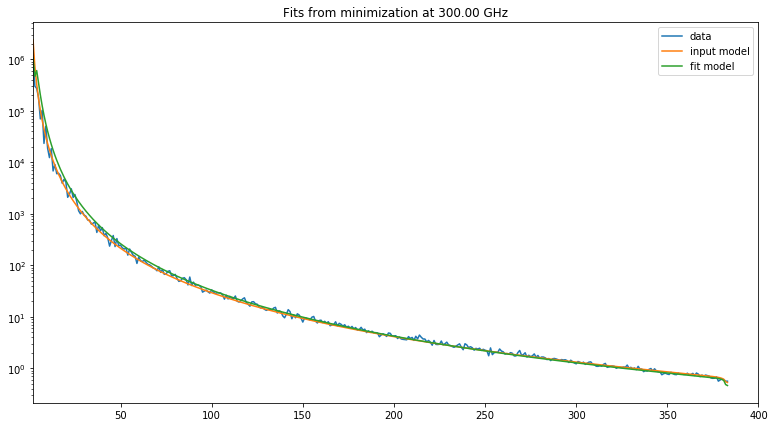

In [116]:
for i in range(len(freqs)):
    figure(figsize=(13,7))
    semilogy(PS_data[i], label='data')
    semilogy(input_model[i], label='input model')
    semilogy(fit7[i], label='fit model')
    title('Fits from minimization at {:.2f} GHz'.format(freqs[i]/1e9))
    legend()
    xlim(2,400)

In [118]:
#let's try starting from very close to correct parameters to see what we get

In [119]:
start=time.time()
result8 = minimize(residuals, [1.6e3, -2.8, -3.4, -2.3], args=(ells, freqs, PS_data),
                   method='L-BFGS-B', bounds=((None, None), (None, None), (None, None), (None, -2.01)))
print(time.time()-start)

544.8711969852448


In [120]:
print(result8)
x8=result8.x

      fun: 1939.1901541939535
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.27373675e-05,  2.81715984e-02, -1.55091584e-01, -1.97637746e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 505
      nit: 75
   status: 0
  success: True
        x: array([1026.19255837,   -2.76934615,   -3.69018944,   -2.01296335])


In [121]:
#interesting. Let's try starting **on** the input parameters

In [122]:
start=time.time()
result9 = minimize(residuals, [A, alpha, beta, gamma], args=(ells, freqs, PS_data),
                   method='L-BFGS-B', bounds=((None, None), (None, None), (None, None), (None, -2.01)))
print(time.time()-start)

510.2092230319977


In [123]:
print(result9)
x9=result9.x

      fun: 1464.7820573430158
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00,  9.09494702e-05, -1.51658242e-02,  0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 470
      nit: 77
   status: 0
  success: True
        x: array([1175.34254954,   -2.95739662,   -2.75765404,  -15.10557109])


In [126]:
#okay, so even starting at the right position doesn't return good results... Weird

In [124]:
fit9 = ff.model(freqs, x9[0], x9[1], x9[2], x9[3])

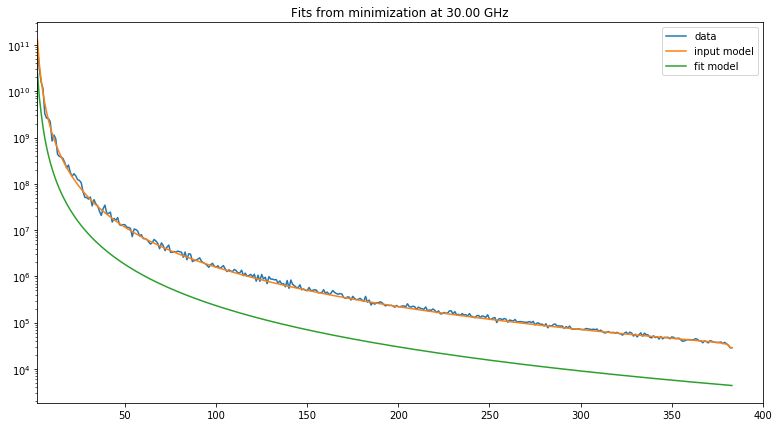

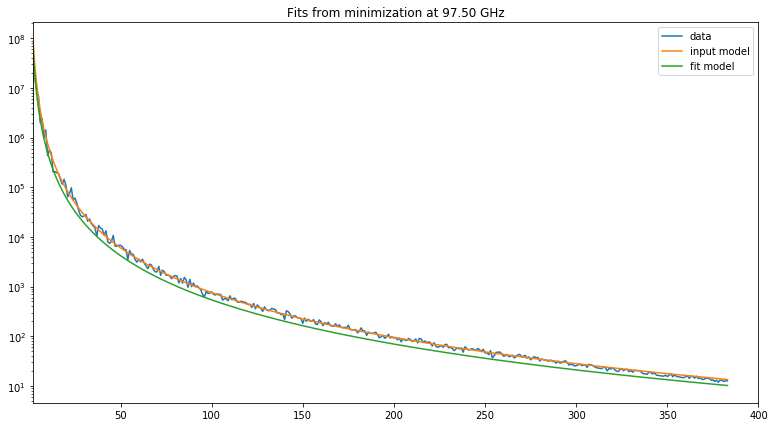

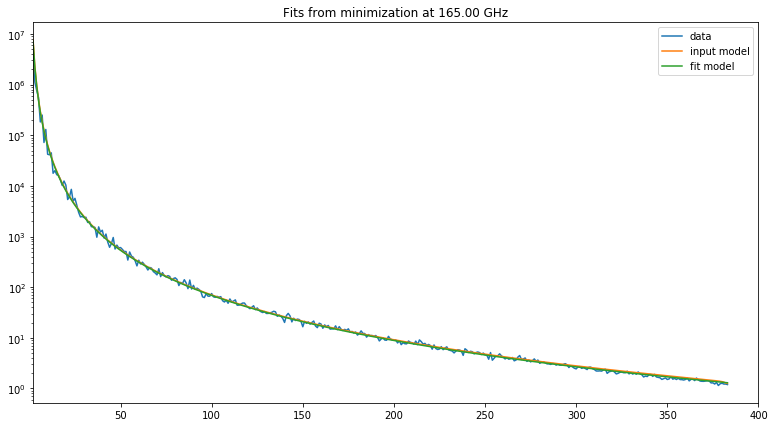

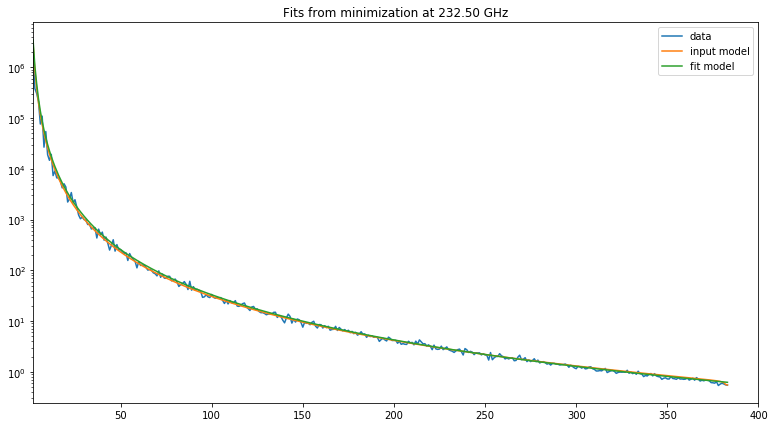

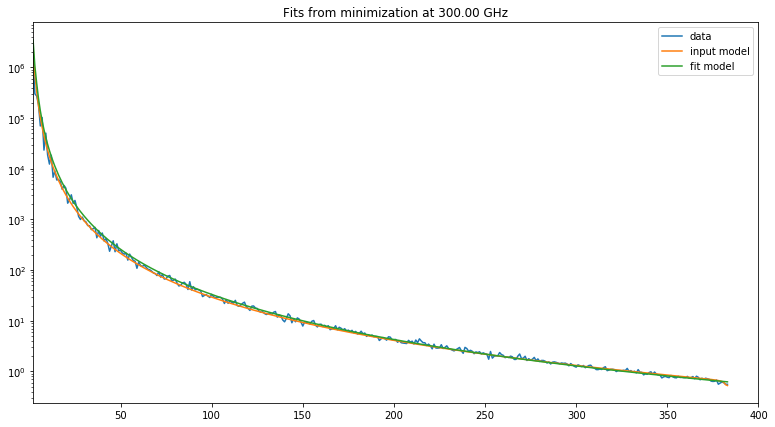

In [125]:
for i in range(len(freqs)):
    figure(figsize=(13,7))
    semilogy(PS_data[i], label='data')
    semilogy(input_model[i], label='input model')
    semilogy(fit9[i], label='fit model')
    title('Fits from minimization at {:.2f} GHz'.format(freqs[i]/1e9))
    legend()
    xlim(2,400)